In [2]:
%load_ext autoreload
%autoreload 2

from spark.utils import get_channel_names, channel_wise_boss, boss_transform_data
import spark.params as params
from spark.preprocessor import load_q_data, load_timeseries_data, train_test_split_ids, Preprocess_Q
from spark.preprocessor import preprocessor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from tsfresh.feature_selection import select_features
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate,GridSearchCV

from pyts.transformation import BOSS

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import joblib

In [3]:
raw_prep_dir  = '../processed_data/'

In [4]:
X_q_data, y_data, id_list = load_q_data(raw_prep_dir + 'merged_dfq.csv')

In [5]:
id_list

0        1
1        2
2        3
3        4
4        5
      ... 
464    465
465    466
466    467
467    468
468    469
Name: id, Length: 469, dtype: int64

In [6]:
X_q_data.head()

,id,age,age_at_diagnosis,bmi,height,weight,gender,handedness,appearance_in_kinship,01,...,21,22,23,24,25,26,27,28,29,30
0,1,56,56,26.061679,173,78,male,right,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,81,69,27.920213,193,104,male,right,False,True,...,True,True,True,False,True,False,True,False,True,False
2,3,45,45,26.989619,170,78,female,right,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,67,63,34.720883,161,90,female,right,False,False,...,True,True,True,False,False,True,True,True,False,False
4,5,75,65,29.069767,172,86,male,left,False,True,...,False,True,True,True,True,True,True,False,False,False


In [7]:
time_data = load_timeseries_data('../processed_data/')

In [8]:
time_data

<xarray.DataArray 'timeseries' (id: 469, channel: 132, timestep: 976)> Size: 242MB
array([[[-7.18307542e-03, -7.97853246e-03, -7.81304389e-03, ...,
          1.72191102e-03,  2.75583961e-03,  1.86453806e-03],
        [-2.89946591e-04, -1.60217297e-03, -2.94661568e-03, ...,
          2.54398095e-04,  1.34622052e-04,  1.96311320e-03],
        [ 4.12839325e-03,  3.16892145e-03,  2.27304758e-03, ...,
          4.87453333e-04,  1.48784160e-03, -4.89200873e-04],
        ...,
        [ 7.97079727e-02,  7.00292438e-02,  4.42504846e-02, ...,
         -1.05950013e-02, -6.27173204e-03,  3.40433232e-03],
        [-1.02272712e-01, -9.49295759e-02, -7.82209039e-02, ...,
          6.99309483e-02,  6.35627955e-02,  5.61850406e-02],
        [-1.67727657e-02, -1.67666413e-02, -2.31204107e-02, ...,
         -1.13539649e-02, -1.77311711e-02, -2.30463073e-02]],

       [[ 8.36125482e-03,  5.90733485e-03, -4.05572727e-03, ...,
         -1.88475254e-03, -9.19213693e-04,  9.88525455e-04],
        [-1.96502102e-03,  2.39871955e-03, -4.03387845e-03, ...,
         -1.77135039e-02, -1.80895422e-02, -1.35900667e-02],
        [ 1.00842845e-02,  1.44647313e-02,  1.11305481e-02, ...,
         -3.04453704e-03, -3.19689699e-03, -2.37555546e-03],
...
         -1.08799472e-01, -9.72944349e-02, -6.82388172e-02],
        [-4.84612212e-02, -2.36799736e-02,  5.07843681e-03, ...,
          1.09375022e-01,  1.36836991e-01,  1.55176848e-01],
        [ 1.09312020e-01,  1.07321836e-01,  1.17433533e-01, ...,
         -4.83003780e-02, -8.27455670e-02, -1.17528580e-01]],

       [[ 1.71402353e-03,  5.86650684e-04,  1.42322108e-03, ...,
         -2.10232858e-04, -3.14288121e-03, -4.14645532e-03],
        [ 4.81363339e-03,  3.89338937e-03,  2.92152795e-03, ...,
          6.13220152e-04,  1.58190704e-03,  6.21251180e-04],
        [ 4.43531526e-03,  3.40049202e-03,  3.71357426e-04, ...,
          1.04908447e-03, -2.86440458e-03, -1.89287565e-03],
        ...,
        [-2.55793445e-02, -3.29656228e-02, -5.21528497e-02, ...,
         -1.21610969e-01, -1.19265735e-01, -1.17108569e-01],
        [-1.36809602e-01, -1.45383656e-01, -1.47666246e-01, ...,
         -1.36324510e-01, -1.57518074e-01, -1.59600675e-01],
        [-1.18657626e-01, -1.21845432e-01, -1.20780163e-01, ...,
         -7.82845020e-02, -7.72348121e-02, -7.40510076e-02]]],
      shape=(469, 132, 976), dtype=float32)
Coordinates:
  * id        (id) int64 4kB 1 2 3 4 5 6 7 8 ... 462 463 464 465 466 467 468 469
  * channel   (channel) <U38 20kB 'Relaxed1_Acceleration_LeftWrist_X' ... 'En...
  * timestep  (timestep) int64 8kB 0 1 2 3 4 5 6 ... 969 970 971 972 973 974 975

In [9]:
X_train_id, X_test_id, y_train, y_test = train_test_split_ids (id_list, y_data, test_size = 0.2, stratify = True)

In [10]:
print(X_train_id.shape, X_test_id.shape)

(375,) (94,)


In [11]:
X_train_time = time_data.sel(id = list(X_train_id))
X_test_time = time_data.sel(id = list(X_test_id))
X_train_q = X_q_data[X_q_data.id.isin(X_train_id)]
X_test_q = X_q_data[X_q_data.id.isin(X_test_id)]
print(X_train_time.to_numpy().shape, X_train_q.shape)

(375, 132, 976) (375, 39)


In [12]:
assert((X_train_time.id.to_numpy() == X_train_q.id.to_numpy()).any)

In [13]:
X_train_time = X_train_time.to_numpy()
X_test_time = X_test_time.to_numpy()

In [14]:
prep = Preprocess_Q(feature_importance = True)
prep.fit(X_train_q)
X_q_train_prep = prep.transform(X_train_q)
X_q_test_prep = prep.transform(X_test_q)
pd.DataFrame(X_q_train_prep)

,0,1,2,3,4,5,6,7,8,9
0,-0.823529,-1.2500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.235294,0.1250,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.058824,0.4375,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,0.823529,0.5625,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.352941,0.5000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
370,0.352941,0.0000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
371,0.176471,0.0000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
372,1.470588,1.1875,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
373,0.823529,0.6875,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [15]:
boss = channel_wise_boss(X_train_time, n_bins = 4, window_step = 2, window_size = 10, word_size = 6)

BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(windo

In [17]:
X_train_boss = boss_transform_data(boss,X_train_time)

1


In [18]:
X_test_boss = boss_transform_data(boss,X_test_time)

1


In [20]:
X_combined_train = np.concatenate((X_train_boss, X_q_train_prep), axis = 1)
X_combined_test = np.concatenate((X_test_boss, X_q_test_prep), axis = 1)
X_combined_train.shape

(375, 384130)

In [22]:
pca_combined = PCA(n_components = 100)
X_pca_combo_train = pca_combined.fit_transform(X= X_combined_train)
X_pca_combo_test = pca_combined.transform(X=X_combined_test)

In [23]:
sv_model_pca_combined = SVC(kernel = 'rbf', class_weight = 'balanced', C = 1, gamma = 'scale')
sv_model_pca_combined.fit(X_pca_combo_train, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [24]:
y_pred_pca_combo = sv_model_pca_combined.predict(X_pca_combo_test)
balanced_accuracy_score(y_test, y_pred_pca_combo)

0.704594861660079

In [25]:
cv_scores = cross_validate(
    sv_model_pca_combined, X_pca_combo_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy'
)

In [26]:
cv_scores

{'fit_time': array([0.00638628, 0.00533295, 0.00470304, 0.00466514, 0.00432801]),
 'score_time': array([0.00326514, 0.00305295, 0.00278926, 0.00273514, 0.00251818]),
 'test_score': array([0.52472089, 0.70185185, 0.62846413, 0.6465294 , 0.64232064])}

In [27]:
param_grid = [
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']},
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['poly'], 'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'], 'degree': [2, 3, 4, 5]},
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']}
]

In [28]:
search = GridSearchCV(
    sv_model_pca_combined,
    param_grid= param_grid,
    scoring='balanced_accuracy',
    cv=5, n_jobs=-1
)

In [41]:
search.fit(X_pca_combo_train, y_train)

,estimator,"SVC(C=1, clas...ht='balanced')"
,param_grid,"[{'C': [0.1, 1, ...], 'kernel': ['linear']}, {'C': [0.1, 1, ...], 'gamma': [0.001, 0.01, ...], 'kernel': ['rbf']}, ...]"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [42]:
search.best_estimator_

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [43]:
y_pred_grid = search.predict(X_pca_combo_test)

In [58]:
balanced_accuracy_score(y_test, y_pred_grid)


0.704594861660079

In [63]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.52      0.94      0.67        16
           1       0.84      0.65      0.73        55
           2       0.55      0.52      0.53        23

    accuracy                           0.67        94
   macro avg       0.63      0.70      0.64        94
weighted avg       0.71      0.67      0.67        94



In [64]:
cv_scores = cross_validate(
    search, X_pca_combo_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy'
)

KeyboardInterrupt: 

In [65]:
cv_scores

{'fit_time': array([2.40234804, 0.67069173, 0.68714285, 0.70998931, 0.66209316]),
 'score_time': array([0.00325108, 0.00198293, 0.00184107, 0.00261593, 0.00295711]),
 'test_score': array([0.52472089, 0.62037037, 0.59440559, 0.6465294 , 0.64232064])}

In [66]:
sv_model_params = search.best_params_
sv_model_params

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [67]:
xgb = XGBClassifier()
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)


xgb = XGBClassifier()

xgb.fit(X_pca_combo_train, y_train, sample_weight=sample_weights)

y_pred_xgb = xgb.predict(X_pca_combo_test)

In [68]:
balanced_accuracy_score(y_test, y_pred_xgb)

0.6673748353096179

In [69]:
#stacked base model without SMOTE & Grid search CV

#base models
base_models = [
    ('svc', SVC(kernel = 'rbf', class_weight = 'balanced', C = 1, gamma = 'scale')),
    ('xgboost', XGBClassifier()),
     ]
#define meta model
meta_model = LogisticRegression(
    class_weight='balanced',
    max_iter=15000
)

#stacking classifier
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    passthrough=True,
    n_jobs=-1
)

#Train
stacked_model.fit(X_pca_combo_train, y_train, sample_weight = sample_weights)

,estimators,"[('svc', ...), ('xgboost', ...)]"
,final_estimator,LogisticRegre...ax_iter=15000)
,cv,StratifiedKFo... shuffle=True)
,stack_method,'auto'
,n_jobs,-1
,passthrough,True
,verbose,0
,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [70]:
stacked_pred = stacked_model.predict(X_pca_combo_test)

In [71]:
balanced_accuracy_score(y_test, stacked_pred)

0.641798418972332

In [52]:
file_name  = 'model_files/combined_sv_reduced_final.joblib'

In [53]:
joblib.dump(search, file_name)

['model_files/combined_sv_reduced_final.joblib']

50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200


KeyboardInterrupt: 

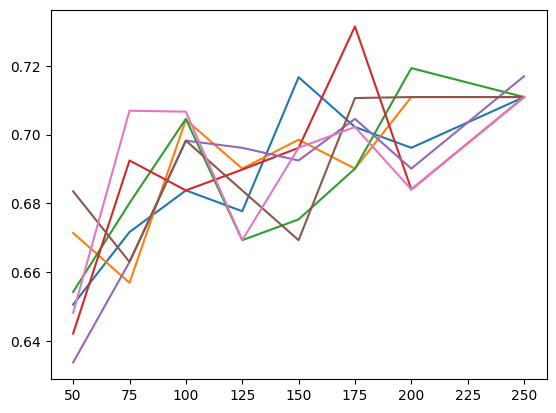

In [54]:
n_comps = [50, 75, 100, 125, 150, 175, 200, 250]

random_state = [1, 3, 7, 9, 13, 23, 33, 99, 123]
for r in random_state:
    accuracy = []
    for n in n_comps:
        print(n)
        pca = PCA(n_components=n, random_state = r)
        X_pca_combo_train = pca.fit_transform(X= X_combined_train)
        X_pca_combo_test = pca.transform(X=X_combined_test)
        sv_model_pca_combined = SVC(kernel = 'rbf', class_weight = 'balanced', C = 1)
        sv_model_pca_combined.fit(X_pca_combo_train, y_train)
        y_pred_pca_combo = sv_model_pca_combined.predict(X_pca_combo_test)
        accuracy.append(balanced_accuracy_score(y_test, y_pred_pca_combo))
    plt.plot(n_comps, accuracy)